In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [13]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X.reshape(-1), Y.reshape(-1))
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], 
             [min(min(X), min(Y)), max(max(X), max(Y))],
             ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

In [32]:
d = 2
n_1 = 2_000 + 100
n_2 = 2_000
sup = 5_000

sqrt_n_1 = int(np.sqrt(n_1))
sqrt_n_2 = int(np.sqrt(n_2))
X_1 = generar_grilla(sqrt_n_1, sup) + np.random.uniform(0,sup/sqrt_n_1/2,(sqrt_n_1**2,2))
X_2 = generar_grilla(sqrt_n_2, sup) + np.random.uniform(0,sup/sqrt_n_2/2,(sqrt_n_2**2,2))

theta_1 = 500
theta_2 = 600
nu_1 = 0.1
nu_2 = 0.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = ( theta_1 + theta_2 ) / 2

rho_12 = gamma(nu_12) / theta_12**nu_12 * np.sqrt(theta_1**nu_1 * theta_2**nu_2 / (gamma(nu_1) * gamma(nu_2))) 
rho_12 = -np.floor(rho_12*1e2)/1e2 # Truncamos a 2 decimales
rho_12

-0.74

In [33]:
X_1, X_2, Y_1, Y_2 = gen_observations(X_1, X_2,
                                      cauchy_model(theta_1, nu_1),
                                      cauchy_model(theta_2, nu_2),
                                      cauchy_model(theta_12, nu_12),
                                      rho_12)

In [34]:
# X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.2)

permutacion = np.random.permutation(len(X_1))
X_1 = X_1[permutacion]
Y_1 = Y_1[permutacion]

n_test = 200

X_test, Y_test = X_1[:n_test], Y_1[:n_test]
X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

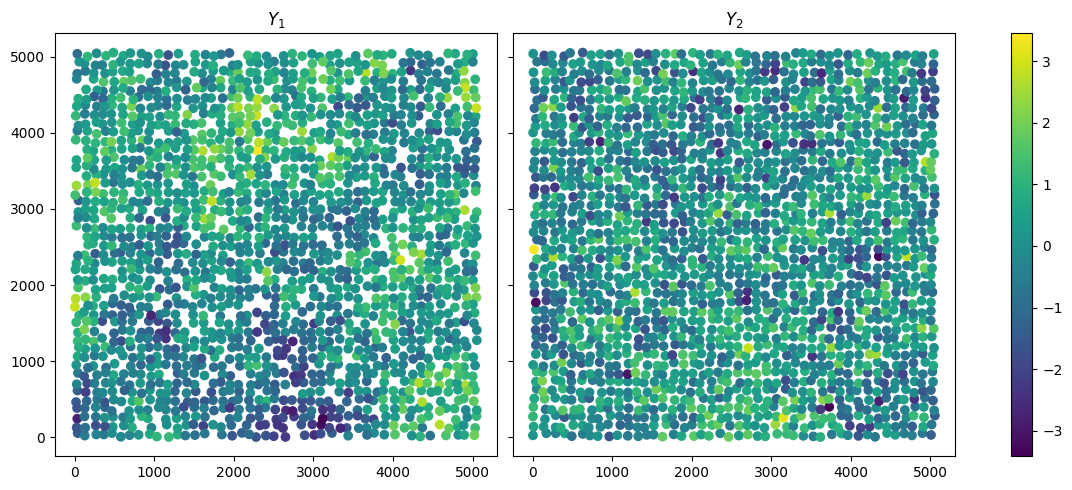

In [35]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

CoKriging

In [36]:
sigma = K(X_1, X_2, cauchy_model(theta_1, nu_1), cauchy_model(theta_2, nu_2), 
          cauchy_model(theta_12, nu_12), rho_12)
Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, cauchy_model(theta_1, nu_1),
           cauchy_model(theta_12, nu_12), rho_12, sigma)
root_mean_squared_error(Y_test, Y_coK)

0.47168871752846353

CoKrigingNN 10%

In [37]:
N = n_2 * 10 // 100
coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, cauchy_model,
                    theta_1, theta_2, theta_12,
                    nu_1, nu_2, nu_12, rho_12)
Y_coKNN = coK_NN.predict(X_test)
root_mean_squared_error(Y_test, Y_coKNN)

0.47220201004158746

NestedCoKriging subsets = 2

In [38]:
n_clusters = n_2 // 2
num_iterations = 1
rmse = 0

for _ in range(num_iterations):
    A_1 = gen_A(X_1, n_clusters)
    A_2 = gen_A(X_2, n_clusters)
    NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, theta_1,
                        theta_2, theta_12, nu_1, nu_2,
                        nu_12, rho_12)
    Y_NcoK = NcoK.predict(X_test, A_1, A_2)
    rmse += root_mean_squared_error(Y_test, Y_NcoK)

rmse / num_iterations

0.47165716494720766

In [44]:
n_clusters = n_2 // 100
A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, theta_1,
                       theta_2, theta_12, nu_1, nu_2,
                       nu_12, rho_12)
Y_pred = NcoK.predict(X_test, A_1, A_2)

root_mean_squared_error(Y_pred, Y_test)

0.4830104486174259

In [29]:
RMSEs_coKNN = []
RMSEs_NcoK = []
times_coKNN = []
times_NcoK = []

ns = [100, 200, 300, 400, 500, 600, 700, 800, 900]
num_iterations = 10

for n in ns:
    RMSE_coKNN = np.zeros(2)
    RMSE_NcoK = np.zeros(2)
    time_coKNN = np.zeros(2)
    time_NcoK = np.zeros(2)

    for _ in range(num_iterations):
        sqrt_n = int(np.sqrt(n))
        X_1 = generar_grilla(sqrt_n, sup) + np.random.uniform(0,sup/sqrt_n/2,(sqrt_n**2,2))
        X_2 = generar_grilla(sqrt_n, sup) + np.random.uniform(0,sup/sqrt_n/2,(sqrt_n**2,2))

        X_1, X_2, Y_1, Y_2 = gen_observations(X_1, X_2,
                                            cauchy_model(theta_1, nu_1),
                                            cauchy_model(theta_2, nu_2),
                                            cauchy_model(theta_12, nu_12),
                                            rho_12)
                
        X_test, Y_test = X_1[:50], Y_1[:50]
        X_1, Y_1 = X_1[50:], Y_1[50:]
        
# NESTED CO KRIGING
        for i, n_clusters in enumerate([n//2, n//50]):
            start_time = time.time()
            A_1 = gen_A(X_1, n_clusters)
            A_2 = gen_A(X_2, n_clusters)
            NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, 
                                   theta_1, theta_2, theta_12, nu_1,
                                   nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)
        
# CO KRIGING NN
        for i, porcentaje in enumerate([5, 30]):    
            start_time = time.time()
            N = n * porcentaje // 100
            coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2,
                                N, cauchy_model, theta_1, theta_2, 
                                theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = coKNN.predict(X_test)
            end_time = time.time()
            
            time_coKNN[i] += (end_time - start_time)
            RMSE_coKNN[i] += root_mean_squared_error(Y_pred, Y_test)
    print(f'{n=} listo :)')
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)    
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)  
    
    times_NcoK.append(time_NcoK / num_iterations)    
    times_coKNN.append(time_coKNN / num_iterations)    

RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

n=100 listo :)
n=200 listo :)
n=300 listo :)
n=400 listo :)
n=500 listo :)
n=600 listo :)
n=700 listo :)
n=800 listo :)
n=900 listo :)


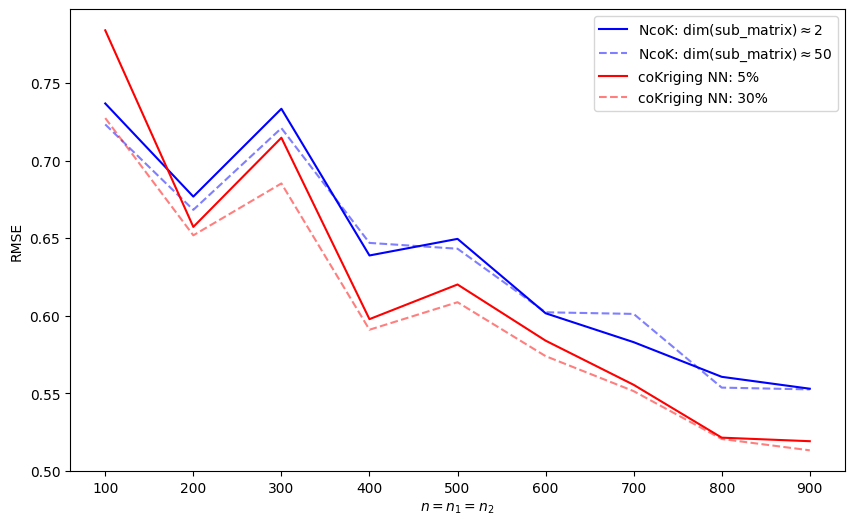

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, RMSEs_coKNN[:, 0], label='coKriging NN: 5%', ls='-', c='r', alpha=1)
plt.plot(ns, RMSEs_coKNN[:, 1], label='coKriging NN: 30%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

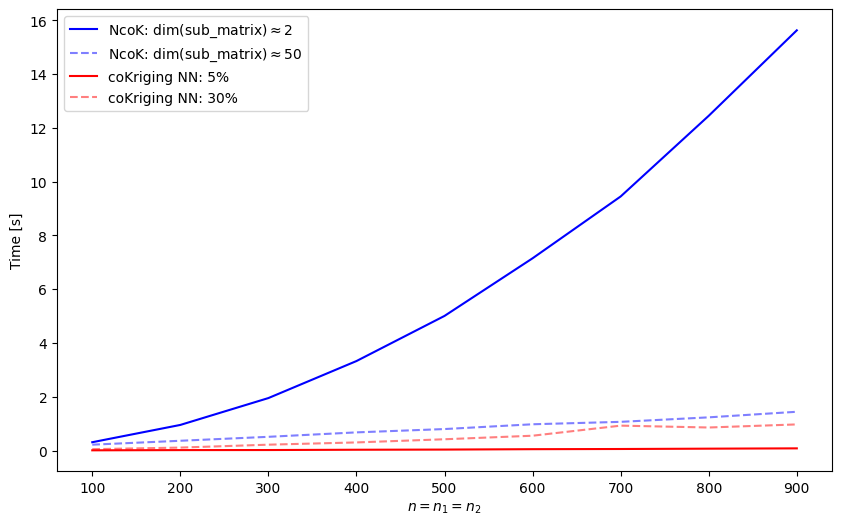

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, times_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, times_coKNN[:, 0], label='coKriging NN: 5%', ls='-', c='r', alpha=1)
plt.plot(ns, times_coKNN[:, 1], label='coKriging NN: 30%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');